Classifier

In [1]:
import os
import random

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

from hypo2.api import RunTime, FitTime
from hypo2.config import RunConfig
from hypo2.dataset import Dataset
from hypo2.model import HIModel
from hypo2.preprocessor import Preprocessor
import torch.nn as nn
import torch
from torchvision.models.inception import Inception3
from torchvision.models.resnet import resnet50
from torchvision.models.resnet import resnet101
from torchvision.models.resnet import resnet152
from tqdm import tqdm_notebook as tqdm
import time


In [2]:
VAL_PATHS = [103, 104, 105, 106, 109, 116]
TRAIN_PATHS = [i for i in range(25)]#[0, 1, -1, -3, 50, 51, 69, 70, 60, 61, 62, 64, 71, 72, 73, 74]
pathids = TRAIN_PATHS
DS_LEN = 5000
N_EPOCHS = 1000000
VAL_EPOCHS = 600
BATCH_SIZE = 5

In [3]:
config = RunConfig()
#config.VERT_RAY_THRESHOLD = 15

In [4]:
paths = FitTime.gen_paths("C:/ml_prj/SchoolHWA/data2")
config.CLASS_COUNT = len(pathids)
config.NN_INPUT_SIZE = (224, 224)
config.FEATURES_COUNT = 300
config.SHEET_ANGLE = 0
pr = Preprocessor(config)
ds = Dataset(config, pr)
DEVICE = torch.device("cuda")

p = paths[0][3]
plt.imshow(Image.open(p))
plt.show()
nmim = pr.open_norm(p)
#plt.figure(figsize=[20, 20])
plt.imshow(nmim)
plt.show()
wordsall = pr.segment_words(nmim)
print(len(wordsall))
plt.imshow(wordsall[0])
plt.show()

In [5]:
X, y = ds.gen_dataset([paths[i] for i in pathids], True)

100 %
Cache was not written because of an error occured


In [6]:
len(X)

28433

In [7]:
def get_x_classes(X, y):
    X_classes = [[] for i in range(np.array(y).max() + 1)]
    for f in range(len(y)):
        X_classes[y[f]].append(X[f])
    return X_classes

In [8]:
def count_distr(fy):
    PS = [0 for i in range(fy.max() + 1)]
    for y in fy:
        PS[y.item()] += 1
    return PS

In [9]:
def get_ds(X_classes, length, todel=False):
    fX = []
    fy = []
    for i in range(length):
        class_id = random.randint(0, config.CLASS_COUNT - 1)
        if len(X_classes[class_id]) > 0:
            dd = random.randint(0, len(X_classes[class_id]) - 1)
            fX.append(X_classes[class_id][dd])
            fy.append(class_id)
            if todel:
                del X_classes[class_id][dd]
    fX = torch.from_numpy(np.stack(fX).transpose((0, 3, 1, 2)).astype(np.float))
    fy = torch.from_numpy(np.stack(fy))
    return fX, fy

In [10]:
def prepare_ds(X, y, length, test=True):
    X_classes = get_x_classes(X, y)
    if test:
        fX_train, fy_train = get_ds(X_classes, length, True)
        fX_test, fy_test = get_ds(X_classes, length, False)
        return fX_train, fy_train, fX_test, fy_test
    else:
        return get_ds(X_classes, length, False)

In [11]:
fX_train, fy_train, fX_test, fy_test = prepare_ds(X, y, DS_LEN, True)

In [12]:
count_distr(fy_train), count_distr(fy_test)

([195,
  203,
  219,
  217,
  208,
  231,
  213,
  202,
  186,
  200,
  221,
  192,
  193,
  217,
  199,
  187,
  185,
  180,
  172,
  196,
  190,
  48,
  212,
  176,
  194],
 [228,
  195,
  197,
  203,
  177,
  215,
  198,
  188,
  215,
  191,
  219,
  198,
  190,
  211,
  217,
  229,
  197,
  194,
  206,
  191,
  191,
  0,
  198,
  208,
  175])

In [13]:
def attach_list_to_obj(obj, props, prefix="module_"):
    for i in range(len(props)):
        exec("obj." + prefix + str(i) + "=props[i]")

def run_over_attr(obj, prefix):
    i = 0
    while hasattr(obj, prefix + str(i)):
        yield eval("obj." + prefix + str(i))
        i += 1

def fmp(a):
    g = 1
    for i in a:
        g *= i
    return g
        
class Flatten(nn.Module):
    def __init__(self, debug=False):
        super().__init__()
        self.debug = debug
    
    def forward(self, x):
        if self.debug:
            print("Original Shape:", x.shape)
        x = x.reshape(x.shape[0], fmp(x.shape[1:]))
        if self.debug:
            print("Final Shape:", x.shape)
        return x

class Cropper(nn.Module):
    def forward(self, x, W, H):
        # B C H W
        #print(x.shape)
        x = x.transpose(0, 3)
        # W C H B
        
        x = x[(x.shape[0] - W) // 2 : (x.shape[0] - W) // 2 + W]
        #print(x.shape)
        x = x.transpose(0, 2)
        # H C W B
        
        x = x[(x.shape[0] - H) // 2 : (x.shape[0] - H) // 2 + H]
        #print(x.shape)
        x = x.transpose(2, 3)
        # H C B W
        #print(x.shape)
        return x.transpose(0, 2)
        # B C H W
    
class MPFlatten(nn.Module):
    def __init__(self, W=0.5, H=0.5):
        super().__init__()
        self.mp = Cropper()
        self.fl = Flatten()
        self.W = W
        self.H = H
    
    def forward(self, x):
        wd = int(self.W * x.shape[3])
        ht = int(self.H * x.shape[2])
        x = self.mp(x, wd, ht)
        return self.fl(x)

class LayerBlock(nn.Module):
    def __init__(self, complexity=3, channels=3):
        super().__init__()
        self.init_l = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.modules = []
        for i in range(complexity):
            self.modules += nn.Conv2d(channels, channels, 3, padding=1), nn.BatchNorm2d(channels)
        self.seq = nn.Sequential(*self.modules)
        self.final_l = nn.Conv2d(channels, channels, kernel_size=1)
    
    def forward(self, x):
        x = self.init_l(x)
        x = self.seq(x)
        x = self.final_l(x)
        return x

class ResSubnet(nn.Module):
    def __init__(self, width, block_count, layer_complexity):
        super().__init__()
        modules = [LayerBlock(layer_complexity, width) for i in range(block_count)]
        attach_list_to_obj(self, modules, "module_")
    
    def forward(self, x):
        r = 0
        for layer in run_over_attr(self, "module_"):
            x = layer(x)
            r += x
        return r

class FeatExtractor(nn.Module):
    def __init__(self, num_classes=10, block_count=7, layer_complexity=3, width=12, imsize=(224, 224)):
        super().__init__()
        self.init_layer = nn.Conv2d(3, width, kernel_size=3, padding=1)
        self.subnet_1 = ResSubnet(width, block_count, layer_complexity)
        #self.middle_layer = nn.Conv2d(width, 3, 3, padding=1)
        #self.subnet_2 = ResSubnet(3, block_count // 2, layer_complexity)
        W, H = 0.6, 0.6
        self.final_layer = nn.Sequential(
            MPFlatten(W, H),
            nn.Linear(int(round(imsize[0] * W) * round(imsize[1] * H) * width), num_classes)
        )
    
    def forward(self, x):
        x = self.init_layer(x)
        x = self.subnet_1(x)
        #x = self.middle_layer(x)
        #x = self.subnet_2(x)
        x = self.final_layer(x)
        return x
        

class SiamBody(nn.Module):
    def __init__(self, FEAT_COUNT, CLASS_COUNT):
        super().__init__()
        #self.i = resnet101(num_classes=FEAT_COUNT)
        #self.i = FeatExtractor(FEAT_COUNT, block_count=8, layer_complexity=3)
        self.i = resnet152(num_classes=FEAT_COUNT)
        '''
        self.i = nn.Sequential(
            nn.Conv2d(3, 3, 3, padding=1),
            Flatten(False),
            nn.Linear(224 * 224 * 3, FEAT_COUNT)
        )
        '''
        self.t = nn.Sequential(
            nn.ReLU(),
            nn.Linear(FEAT_COUNT, CLASS_COUNT),
            nn.Softmax()
        )
        #self.t.requires_grad = False
        # self.t = DyPa(35, [3, 5, 7], (299, 299), CLASS_COUNT, dev)
        #self.f = SpherePoint()

    def forward(self, x):
        x = self.i(x)
        x = self.t(x)
        return x

In [14]:
def add_padding_4(res, pattern):
    before_0 = -(res.shape[3] - pattern[0]) // 2
    after_0 = -(res.shape[3] - pattern[0]) // 2 + (res.shape[3] - pattern[0]) % 2
    before_1 = -(res.shape[2] - pattern[1]) // 2
    after_1 = -(res.shape[2] - pattern[1]) // 2 + (res.shape[2] - pattern[1]) % 2
    return np.pad(res, [(0, 0), (0, 0), (before_1, after_1), (before_0, after_0)], mode="constant", constant_values=1)

def runtime_preprocess(bX, dev):
    bX = torch.tensor(add_padding_4(1 - (bX + 1/2), (config.NN_INPUT_SIZE[0], config.NN_INPUT_SIZE[1])))
    tnoise = torch.from_numpy(np.stack([np.stack([np.random.randn(config.NN_INPUT_SIZE[0], config.NN_INPUT_SIZE[1])] * 3, axis=2) / 30 for j in range(bX.shape[0])])).transpose(1, 3)
    return (1 - (bX.type(torch.float) + tnoise.type(torch.float)).to(dev))

In [15]:
model = SiamBody(config.FEATURES_COUNT, config.CLASS_COUNT).to(DEVICE)
#model = torch.load("D:/main/ml_prj/SchoolHWA/class_models/h1562090952_0.8833333333333333_10_classes.h5")

In [16]:
d = count_distr(fy_train)
crit = nn.CrossEntropyLoss(weight=torch.tensor(1 / np.array(d)).to(DEVICE).type(torch.float))
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

In [17]:
losses = []
accs = []
g_losses = []
g_accs = []

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


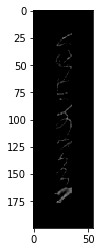

In [18]:
plt.imshow(fX_train[4].transpose(0, 2))

In [19]:
def mp(a):
    f = 1
    for i in a.shape:
        f *= i
    return f

for i in model.parameters():
    print(mp(i))

9408
64
64
4096
64
64
36864
64
64
16384
256
256
16384
256
256
16384
64
64
36864
64
64
16384
256
256
16384
64
64
36864
64
64
16384
256
256
32768
128
128
147456
128
128
65536
512
512
131072
512
512
65536
128
128
147456
128
128
65536
512
512
65536
128
128
147456
128
128
65536
512
512
65536
128
128
147456
128
128
65536
512
512
65536
128
128
147456
128
128
65536
512
512
65536
128
128
147456
128
128
65536
512
512
65536
128
128
147456
128
128
65536
512
512
65536
128
128
147456
128
128
65536
512
512
131072
256
256
589824
256
256
262144
1024
1024
524288
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
5

In [20]:
model.train(True)

SiamBody(
  (i): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64,

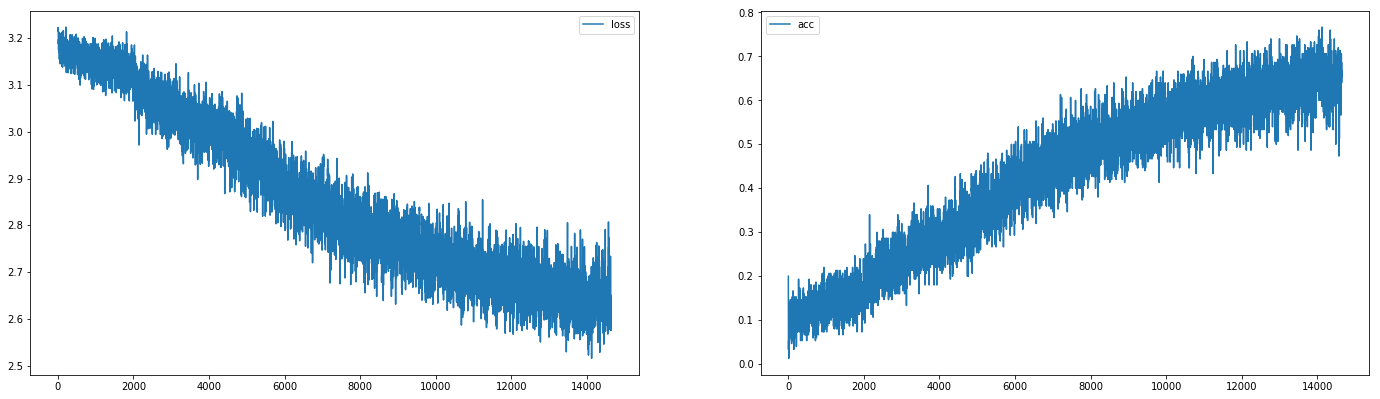

acc: 0.649
loss: 2.636
2.2 epochs per second
455.37 seconds for 1000 epochs


In [ ]:
import time
REDRAW_SIZE = 20

lasttime = time.time()
for i in range(N_EPOCHS * 1):
    batch_id = random.randint(0, len(fX_train) - BATCH_SIZE)
    X_b = runtime_preprocess(fX_train[batch_id : batch_id + BATCH_SIZE], DEVICE)
    ytrue = fy_train[batch_id : batch_id + BATCH_SIZE]
    ypred = model(X_b)
    loss = crit(ypred, ytrue.to(DEVICE).type(torch.long))
    loss.backward()
    opt.step()
    opt.zero_grad()

    all = BATCH_SIZE
    s = torch.argmax(ypred.cpu(), dim=1) == ytrue.type(torch.long)
    accs.append(s.sum().item() / all)
    losses.append(loss.item())
    g_accs.append(sum(accs[-30:]) / len(accs[-30:]))
    g_losses.append(sum(losses[-30:]) / len(losses[-30:]))
    
    
    if i % REDRAW_SIZE == REDRAW_SIZE - 1:
        clear_output(True)
        plt.figure(figsize=[24, 6.7])
        plt.subplot(1, 2, 1)
        plt.plot(g_losses[::10], label="loss")
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(g_accs[::10], label="acc")
        plt.legend()
        plt.show()
        print("acc:", round(sum(g_accs[-1 - REDRAW_SIZE : -1]) / REDRAW_SIZE, 3))
        print("loss:", round(sum(g_losses[-1 - REDRAW_SIZE : -1]) / REDRAW_SIZE, 3))
        tm = time.time()
        tmgone = tm - lasttime
        lasttime = tm
        print(round(REDRAW_SIZE / tmgone, 2), "epochs per second")
        print(round(1000 * tmgone / REDRAW_SIZE, 2), "seconds for 1000 epochs")
    if i % 10000 == 0:
        torch.save(model, "D:/main/ml_prj/SchoolHWA/25_class_model/h" + str(int(time.time())) + "_" + str(len(pathids)) + "_classes.h5")

In [ ]:
def find_intersection(fX1, fX2):
    for x1 in tqdm(fX1):
        for x2 in fX2:
            if ((x1 - x2)**2).sum() < 0.001:
                return (x1, x2)
    return 0

def count_intersection(fX1, fX2):
    r = 0
    for x1 in tqdm(fX1):
        for x2 in fX2:
            if ((x1 - x2)**2).sum() < 0.001:
                r += 1
    return r

In [ ]:
model.train(False)
None

In [ ]:
all = 0
s = 0
for i in tqdm(range(VAL_EPOCHS)):
    batch_id = random.randint(0, len(fX_test) - BATCH_SIZE)
    X_b = runtime_preprocess(fX_test[batch_id : batch_id + BATCH_SIZE], DEVICE)
    ytrue = fy_test[batch_id : batch_id + BATCH_SIZE]
    ypred = model(X_b)
    all += BATCH_SIZE
    s += (torch.argmax(ypred.cpu(), dim=1) == ytrue.type(torch.long)).sum().item()
acc = s / all
print("Final acc:", acc)

In [ ]:
torch.save(model, "D:/main/ml_prj/SchoolHWA/class_models/h" + str(int(time.time())) + "_" + str(acc) + "_" + str(len(pathids)) + "_classes.h5")

Research

In [ ]:
config.CLASS_COUNT = len(VAL_PATHS)

In [ ]:
vX, vy = ds.gen_dataset([paths[i] for i in VAL_PATHS], True)

In [ ]:
vX_t, vy_t = prepare_ds(vX, vy, DS_LEN, False)

In [ ]:
def get_fXl_fyl(vX_tr, vy_tr, classes=None):
    if classes == None:
        vX_t, vy_t = vX_tr, vy_tr
    else:
        vX_t, vy_t = [], []
        for i in range(len(vX_tr)):
            if vy_tr[i] in classes:
                vX_t.append(vX_tr[i])
                vy_t.append(vy_tr[i])
        vX_t = torch.stack(vX_t)
        vy_t = torch.stack(vy_t)
    fXl = []
    fyl = []
    for i in tqdm(range(len(vy_t))):
        rad = random.randint(0, len(vX_t) - BATCH_SIZE)
        if True:
            x = vX_t[rad : rad + BATCH_SIZE]
            p3 = runtime_preprocess(x, DEVICE)
            fXl.extend(model.i(p3).detach())
            #fXl.append(model.i(torch.stack([p3[0]] * 5)).detach()[0])
            #fXl.extend(model.i(torch.stack([p3[0], p3[0], p3[0], p3[0], p3[0]])).detach())
            #fXl.extend(list(model(p3).detach()))
            fyl.extend(vy_t[rad : rad + BATCH_SIZE])
            #fyl.append(vy_t[rad : rad + BATCH_SIZE][0])
            #fyl.extend([vy_t[rad : rad + BATCH_SIZE][0]] * 5)
        #if i % 10 == 0:
            #print(i)
    return fXl, fyl
#fXl, fyl = get_fXl_fyl(fX_train, fy_train)
#fXl, fyl = get_fXl_fyl(vX_t, vy_t, [0, 2])
fXl, fyl = get_fXl_fyl(vX_t, vy_t)

In [ ]:
def build_comp(fXl, fyl, comp):
    tsne = comp(n_components=2)
    vecs = tsne.fit_transform([l.tolist() for l in fXl])
    onearr = []
    for i in range(len(vecs)):
        onearr.append((vecs[i], fyl[i]))
    colors = sorted(onearr, key=lambda x: x[1])
    diffars = [list() for i in range(colors[-1][1] + 1)]
    for col in colors:
        diffars[col[1]].append(col[0])
    for diffarr in diffars:
        plt.scatter([v[0] for v in diffarr], [v[1] for v in diffarr])
    plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
plt.figure(figsize=[20, 12])
build_comp(fXl, fyl, TSNE)

Distance

In [ ]:
the_same_person = []
different_people = []
for i in range(1000):
    i1 = random.randint(0, len(fXl) - 1)
    i2 = random.randint(0, len(fXl) - 1)
    if i1 == i2:
        continue
    d = ((fXl[i1] - fXl[i2]) ** 2).sum().item()
    if fyl[i1] == fyl[i2]:
        the_same_person.append(d)
    else:
        different_people.append(d)

In [ ]:
import seaborn as sns
sns.distplot(the_same_person, label="one")
sns.distplot(different_people, label="two")
plt.legend()

Gravity

In [ ]:
def DOGRAVITY():
    G_EPOCHS = 1000
    G_LR = 1.0e-6
    G_BATCH_SIZE = 5
    model.i.train(True)
    opt = torch.optim.Adam(model.i.parameters(), lr=G_LR)
    crit = torch.nn.MSELoss()
    G_losses = []
    G_g_losses = []
    for i in range(G_EPOCHS * 0):
        batch_id = random.randint(0, len(fX_train) - G_BATCH_SIZE)
        X_b = runtime_preprocess(fX_train[batch_id : batch_id + G_BATCH_SIZE], DEVICE)
        ytrue_ids = fy_train[batch_id : batch_id + G_BATCH_SIZE]
        ytrue = []
        for ytrue_id in ytrue_ids:
            ytrue.append(class_centers[ytrue_id])
        ytrue = torch.stack(ytrue)
        ypred = model.i(X_b)
        loss = crit(ypred, ytrue)
        loss.backward()
        opt.step()
        opt.zero_grad()

        all = G_BATCH_SIZE
        G_losses.append(loss.item())
        G_g_losses.append(sum(G_losses[-30:]) / len(G_losses[-30:]))
        clear_output(True)
        plt.plot(G_g_losses, label="loss")
        plt.show()
        print("loss:", round(G_g_losses[-1], 3))

In [ ]:
from hypo2.preprocessor import Preprocessor
config.VERT_RAY_THRESHOLD = "adaptive"
pr = Preprocessor(config)

In [ ]:
sokolovacfg = config.copy()
sokolovacfg.VERT_RAY_THRESHOLD = 35
otherscfg = config.copy()
otherscfg.VERT_RAY_THRESHOLD = 15
sokolovapr = Preprocessor(sokolovacfg)
otherspr = Preprocessor(otherscfg)

In [ ]:
def FIXFUCKINGBUGSSHIT(l):
    #for i in range(len(l)):
    #    l[i] = (1 - l[i] / 255) - 1/2
    return l

In [ ]:
words1 = FIXFUCKINGBUGSSHIT(otherspr.open_norm_segm("C:/ml_prj/SchoolHWA/data2/003-Danilova-V.E/1.png"))
print(len(words1))
words2 = FIXFUCKINGBUGSSHIT(otherspr.open_norm_segm("C:/ml_prj/SchoolHWA/data2/003-Danilova-V.E/2.png"))
print(len(words2))
words3 = FIXFUCKINGBUGSSHIT(sokolovapr.open_norm_segm("C:/ml_prj/SchoolHWA/data2/100-Sokolova-V.A/1.png"))
print(len(words3))
words4 = FIXFUCKINGBUGSSHIT(sokolovapr.open_norm_segm("C:/ml_prj/SchoolHWA/data2/100-Sokolova-V.A/3.png"))
print(len(words4))
words5 = FIXFUCKINGBUGSSHIT(otherspr.open_norm_segm("C:/ml_prj/SchoolHWA/data2/101-Orlova-S.E/1.png"))
print(len(words5))
words6 = FIXFUCKINGBUGSSHIT(otherspr.open_norm_segm("C:/ml_prj/SchoolHWA/data2/101-Orlova-S.E/2.png"))
print(len(words6))

In [ ]:
print(len(words1), len(words2), len(words3), len(words4), len(words5), len(words6))

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def get_points(model, words, dev):
    model.train(False)
    r = []
    for word in words:
        #print(word.transpose((1, 2, 0)).shape)
        x = runtime_preprocess(np.stack([word.transpose((2, 1, 0))]), dev)
        r.append(model.i(x).cpu().detach())
    return r

def count_center(points):
    return sum(points) / len(points)

def count_dist(center1, center2):
    return ((center1 - center2) ** 2).sum() ** 0.5

In [ ]:
dist_s1 = count_dist(get_points(model, words1, DEVICE), get_points(model, words2, DEVICE))
dist_d1 = count_dist(get_points(model, words1, DEVICE), get_points(model, words3, DEVICE))
dist_s2 = count_dist(get_points(model, words3, DEVICE), get_points(model, words4, DEVICE))
dist_d2 = count_dist(get_points(model, words2, DEVICE), get_points(model, words4, DEVICE))
dist_s3 = count_dist(get_points(model, words5, DEVICE), get_points(model, words6, DEVICE))
dist_d3 = count_dist(get_points(model, words3, DEVICE), get_points(model, words5, DEVICE))
dist_d4 = count_dist(get_points(model, words1, DEVICE), get_points(model, words6, DEVICE))
print("The same:", dist_s1, dist_s2, dist_s3)
print("Different:", dist_d1, dist_d2, dist_d3, dist_d4)

In [ ]:
wowaswords = FIXFUCKINGBUGSSHIT(pr.open_norm_segm("C:/ml_prj/SchoolHWA/realpeople/Wowa/20190702_180940.jpg"))

In [ ]:
count_dist(get_points(model, words5, DEVICE), get_points(model, wowaswords, DEVICE))

In [ ]:
W = 1200
SIZE = (W, round(W * 1350 / 1800))

In [ ]:
artemrandom = otherspr.segment_words(pr.norm(Image.open("C:/ml_prj/SchoolHWA/realpeople/Artem/artem_random_or.bmp").resize(SIZE)))
artempikabu = otherspr.segment_words(pr.norm(Image.open("C:/ml_prj/SchoolHWA/realpeople/Artem/artem_pikabu_or.bmp").resize(SIZE)))
levrandom = otherspr.segment_words(pr.norm(Image.open("C:/ml_prj/SchoolHWA/realpeople/Lev/lev_random_or.bmp").resize(SIZE)))
levpikabu = otherspr.segment_words(pr.norm(Image.open("C:/ml_prj/SchoolHWA/realpeople/Lev/lev_pikabu_or.bmp").resize(SIZE)))

In [ ]:
artemrandom = FIXFUCKINGBUGSSHIT(artemrandom)
artempikabu = FIXFUCKINGBUGSSHIT(artempikabu)
levrandom = FIXFUCKINGBUGSSHIT(levrandom)
levpikabu = FIXFUCKINGBUGSSHIT(levpikabu)

In [ ]:
pikabu_dist = count_dist(get_points(model, artempikabu, DEVICE), get_points(model, levpikabu, DEVICE))
random_dist = count_dist(get_points(model, artemrandom, DEVICE), get_points(model, levrandom, DEVICE))
disp_lev = count_dist(get_points(model, levrandom, DEVICE), get_points(model, levpikabu, DEVICE))
disp_artem = count_dist(get_points(model, artempikabu, DEVICE), get_points(model, artemrandom, DEVICE))

In [ ]:
print("Pikabu test (Hard):", pikabu_dist, "must be high")
print("Random test (Easy):", random_dist, "must be high")
print("Lev and Artem disps (middle):", disp_lev, disp_artem, "both must be low")

### Full validation

In [ ]:
VALPATHCOUNT = 100
valpaths = [i for i in range(len(paths))][:VALPATHCOUNT]
i = 0
while i < len(valpaths):
    if valpaths[i] in (TRAIN_PATHS + VAL_PATHS):
        del valpaths[i]
    else:
        i += 1

In [ ]:
valcfg = config.copy()
valcfg.VERT_RAY_THRESHOLD = 19 
valpr = Preprocessor(valcfg)
pointss = []
PAX = 200
for val_id in tqdm(valpaths):
    cpaths = paths[val_id]
    w = []
    for p in cpaths:
        try:
            w.extend(FIXFUCKINGBUGSSHIT(valpr.open_norm_segm(p)))
        except:
            pass
    if len(w) < 2 * PAX:
        print(val_id, "missed, not enough words:", len(w))
        continue
    pointss.append([])
    for i in range(len(w) // PAX):
        pointss[-1].append(count_center(get_points(model, w[i * PAX : (i + 1) * PAX], DEVICE)))

In [ ]:
for p in pointss:
    print(len(p))

In [ ]:
X_dists = []
y_dists = []
for pss in tqdm(pointss):
    for i in range(len(pss)):
        for j in range(i + 1, len(pss)):
            X_dists.append(count_dist(pss[i], pss[j]).item())
            y_dists.append(0)

In [ ]:
zero_count = len(y_dists)
for i in range(zero_count):
    random.shuffle(pointss)
    s1 = pointss[0]
    s2 = pointss[1]
    ps1 = random.choice(s1)
    ps2 = random.choice(s2)
    X_dists.append(count_dist(ps1, ps2).item())
    y_dists.append(1)

In [ ]:
def countacc(X, y, thr):
    s = 0
    for i in range(len(X)):
        if (X[i] < thr and y[i] == 0) or (X[i] > thr and y[i] == 1):
            s += 1
    return s / len(X)

In [ ]:

allnums = sorted(X_dists)
ns = []
bacc, bh = 0, 0
for i in tqdm(range(0, len(allnums) - 1, max(300 // (PAX ** 2), 1))):
    thr = (allnums[i] + allnums[i + 1]) / 2
    acc = countacc(X_dists, y_dists, thr)
    ns.append(acc)
    if acc > bacc:
        bacc = acc
        bh = thr
plt.plot(ns)

In [ ]:
print("Best accuracy:", bacc)
print("Best threshold:", bh)

In [ ]:
countacc(X_dists, y_dists, 70)

In [ ]:
plt.scatter(X_dists, y_dists)

| WORD COUNT | BEST THR | BEST RESULT | 70.0 | 33.0 | 12.8 |
|:----------:|----------|-------------|------|------|------|
| 1          | 70.0     | 64%         | 64%  |  -   |  -   |
| 2          | 48.0     | 68%         | 68%  | 67%  | 52%  |
| 10         | 33.0     | 75%         | 64%  | 75%  | 63%  |
| 25         | 21.0     | 82%         | 66%  | 79%  | 75%  |
| 45         | 18.0     | 85%         | 69%  | 81%  | -    |
| 90         | 14.1     | 87%         | 66%  | 79%  | -    |
| 250        | 12.8     | 95%         | 50%  | 71%  | 95%  |


In [ ]:
thrs = [70, 48, 33, 21, 18, 14.1, 12.8]
wcs  = [1, 2, 10, 25, 45, 90, 250]
plt.plot(wcs, thrs)